# Global Diferential Privacy Assessement: Univariate case

In this notebook, we will explore the univariate case of the Global Differential Privacy using a dataset from use case 2.1. After running this notebook, you will be able to:
- Understand the concept of Global Differential Privacy.
- Apply Global Differential Privacy to a univariate dataset.

We also run a monte carl simulation to validate the GDP implementation.

## Import data and visualise

The data are imported and only available via 'pipelines' i.e. automations made by a user. As such GDP operates on the user pipeline and not directly on the data.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, shutil
! pip install wget --quiet 
import wget


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [24]:
os.makedirs("data", exist_ok=True)
link_original = "https://s3.amazonaws.com/openneuro.org/ds004148/participants.tsv?versionId=wt81Mu2B3fdeiXSis5ym288A64lXRXkR"
wget.download(link_original)
filename = "participants.tsv"
file_ = [os.path.join(root, file) for root, _, files in os.walk(os.getcwd()) for file in files if file == filename]
shutil.copy2(file_[0], "data")
os.remove(file_[0])
print(f"\nOriginal file downloaded.")

data = np.array(pd.read_csv("data/"+filename,sep='\s+')["Height"]).reshape(-1,1)
clean_data = data[~np.isnan(data)]
print(f"\n\tClean data: {clean_data}")

100% [..........................................................] 39886 / 39886
Original file downloaded.

	Clean data: [178.   155.   169.   157.   171.   166.   167.   175.   165.   160.
 160.   156.   155.   162.   168.   165.   163.   164.   172.   180.
 160.   160.   160.   174.   162.   164.   173.   168.   160.   160.
 170.   185.   177.   177.   182.   175.   165.   175.   180.   165.
  58.   185.     1.65 167.   153.   174.   173.   175.   167.   170.
 178.   185.   172.   157.   172.   157.   171.   163.  ]


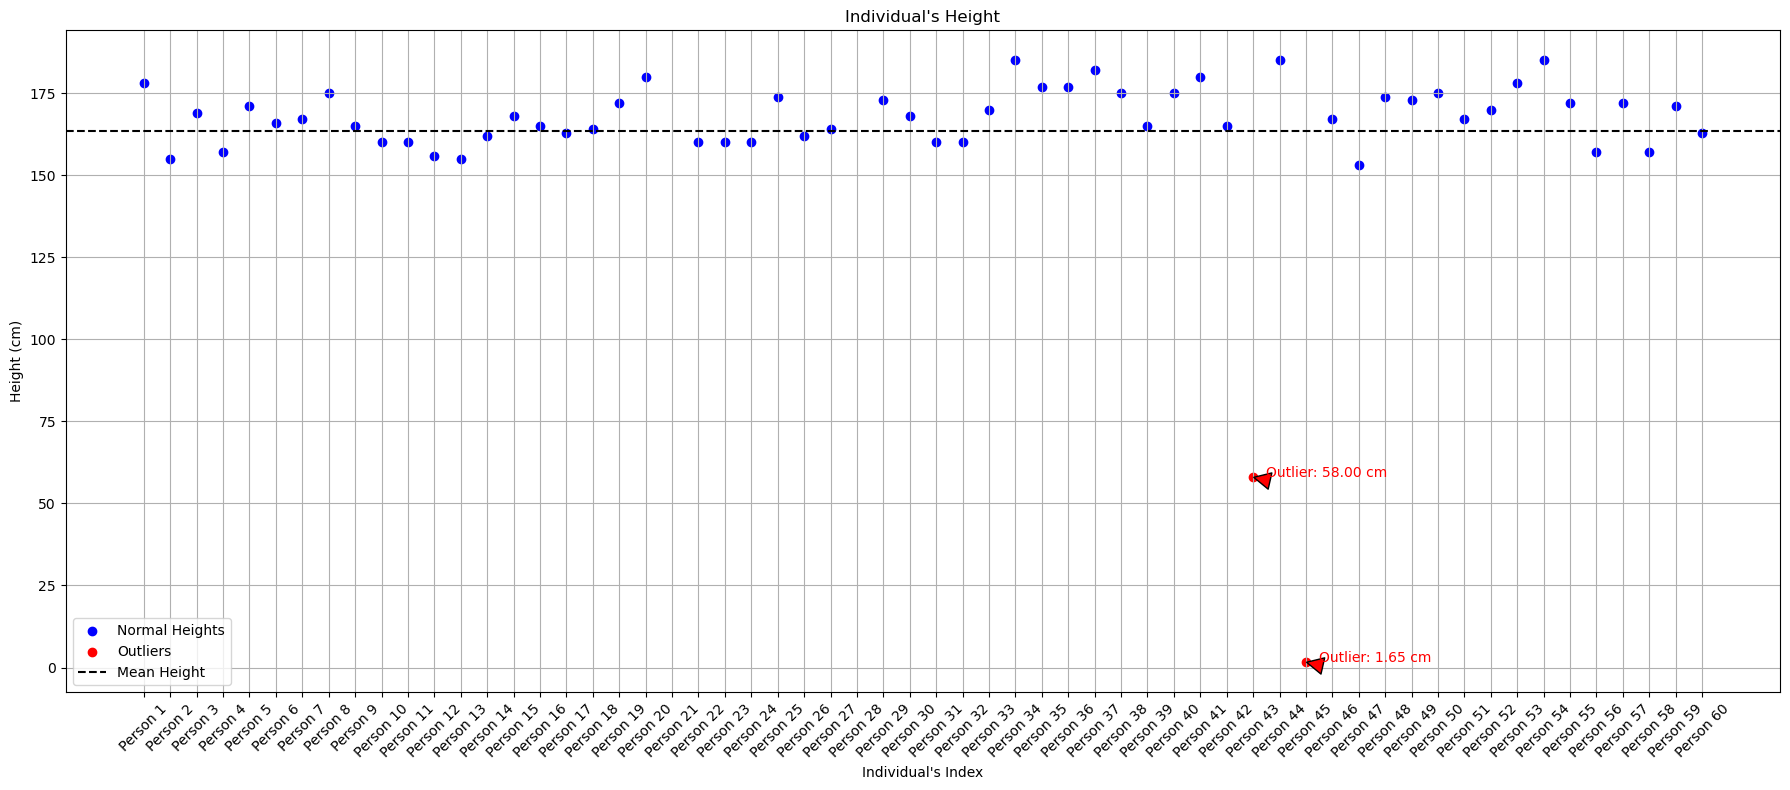

In [25]:
data = np.array(pd.read_csv("data/"+filename,sep='\s+')["Height"]).reshape(-1,1)

clean_data = data[~np.isnan(data)]
q1 = np.percentile(clean_data, 25)
q3 = np.percentile(clean_data, 75)
iqr = q3 - q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr

outlier_indices = np.where((data < lower_bound) | (data > upper_bound))[0]
plt.figure(figsize=(18, 8))
normal_indices = [i for i in range(len(data)) if i not in outlier_indices and i not in outlier_indices]
plt.scatter(normal_indices, data[normal_indices], color='blue', label='Normal Heights')
plt.scatter(outlier_indices, data[outlier_indices], color='red', label='Outliers')

for outlier_idx in outlier_indices:
    plt.annotate(f'Outlier: {data[outlier_idx][0]:.2f} cm',
                xy=(outlier_idx, data[outlier_idx]),
                xytext=(outlier_idx+0.5, data[outlier_idx]),
                arrowprops=dict(facecolor='red', shrink=0.05),
                color='red')
plt.axhline(np.nanmean(data), color='black', linestyle='--', label='Mean Height')
plt.title("Individual's Height")
plt.xlabel("Individual's Index")
plt.xticks(range(len(data)), [f"Person {i + 1}" for i in range(len(data))], rotation=45)
plt.ylabel("Height (cm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Global Differential Privacy

Global Differential Privacy (DP) is a mathematical framework that provides strong, quantifiable privacy guarantees when analyzing and sharing data. Its core idea is to ensure that the inclusion or exclusion of a single individual’s data does not significantly affect the output of an analysis, thereby limiting what can be inferred about any one person. This limits the ability of an attacker to infer whether someone participated in the dataset, even if they possess additional background information. To achieve this, DP algorithms inject calibrated random noise into outputs.

## User Output

A data user has an analysis pipeline that s run on the data. The output of such pipeline is then made differentially private.

Here, the pipeline simply consists in computing the mean.


In [26]:
def user_output(clean_data):

    pipeline_output = np.mean(clean_data)
    return pipeline_output

In [27]:
pipeline_output = user_output(clean_data)
print("the true mean is: ", user_output(clean_data))

the true mean is:  163.42499999999998


## GDP algorithm

The procedure take the user pipeline and data and applies a leave one out (loo) resampling to the data to obtain the influence function, i.e. the output of the user pipeline for each loo resample are compared to the user output. The maximum of that gives the lower bound of the noise to be applied (i.e. it provides the information on the observation which has the largest influence).  



In [28]:
loo_data = np.array([np.delete(clean_data, i) for i in range(len(clean_data))])
print(f"\n\tall loo data: {loo_data}")


	all loo data: [[155. 169. 157. ... 157. 171. 163.]
 [178. 169. 157. ... 157. 171. 163.]
 [178. 155. 157. ... 157. 171. 163.]
 ...
 [178. 155. 169. ... 172. 171. 163.]
 [178. 155. 169. ... 172. 157. 163.]
 [178. 155. 169. ... 172. 157. 171.]]


In [29]:
loo_output = np.array([user_output(np.delete(clean_data, i)) for i in range(len(clean_data))])
print(f"\n\tall loo mean values: {loo_output}")
print(f"\n\tloo for outliers: {loo_output[outlier_indices]}")


	all loo mean values: [163.16929825 163.57280702 163.32719298 163.5377193  163.29210526
 163.37982456 163.3622807  163.22192982 163.39736842 163.48508772
 163.48508772 163.55526316 163.57280702 163.45       163.34473684
 163.39736842 163.43245614 163.41491228 163.2745614  163.13421053
 163.48508772 163.48508772 163.48508772 163.23947368 163.45
 163.41491228 163.25701754 163.34473684 163.48508772 163.48508772
 163.30964912 163.04649123 163.18684211 163.18684211 163.09912281
 163.22192982 163.39736842 163.22192982 163.13421053 163.39736842
 165.2745614  163.04649123 166.26315789 163.3622807  163.60789474
 163.23947368 163.25701754 163.22192982 163.3622807  163.30964912
 163.16929825 163.04649123 163.2745614  163.5377193  163.2745614
 163.5377193  163.29210526 163.43245614]

	loo for outliers: [166.26315789 163.60789474]


In [30]:
sensitivity = np.max(np.abs(loo_output - pipeline_output))
print(f"\n\tsensitivity: {sensitivity}")


	sensitivity: 2.8381578947368666


## Sampling from a noise distribution

Of course the noise value has to come from somewhere. Here we choose a Laplace distribution centred on 0 with the scale equal to variance of loo means, ie reflecting how much change we have due to single observations.

In [31]:
loo_scale = np.std(loo_output)
print(f"\n\tnoise scale: {loo_scale}")

while True:
    noise_batch = np.random.normal(loc=0.0, scale=loo_scale, size=100)
    valid = noise_batch[np.abs(noise_batch) >= sensitivity]
    if valid.size > 0:
        noise = valid[0]
        break
        
print(f"\n\tnoise: {noise}")
gdp_resut = pipeline_output + noise;
print(f"\n\tgdp result: {gdp_resut}")


	noise scale: 0.47422918086144344

	noise: 2.8778104860605134

	gdp result: 166.3028104860605


## Validation

Here we use monte carlo simulations to show that the results are differentially private.
Since GDP is defined by the influence of a single observation, we resample the data with replacement (bootstrap) to generate 1000 replicats. For each replicats, the user is asking for leave one out means, which will allow to reconstruct the data if not noisy (see notebook 1). Here, for each of those outpouts, noise is added, and we show that the user cannot reconstruct the data nor even identify outliers.

we start by defining the object dp, which simply add noise as explained above, and reuse this for the user outputs

In [13]:
sample_data = np.random.normal(loc=170, scale=10, size=len(clean_data) - 1)
sample_data = np.append(sample_data, 58)
print(f"Sample data:\n\n {sample_data}")

Sample data:

 [165.92584826 174.34124216 180.30834273 179.17126639 173.28964551
 174.67401267 193.39006405 175.77416835 173.45693262 175.26646543
 162.34049128 162.09530107 171.66784047 166.24219579 160.16975374
 176.28265471 161.7184209  163.40946518 166.44611818 168.6913493
 173.69925408 194.09942941 157.30581954 181.35244923 176.0027453
 183.75482105 166.01662821 163.59588137 167.33617513 168.56380115
 167.93770006 185.94389748 166.70140971 148.07689911 149.40486162
 182.17335125 184.50202647 158.69537915 163.5561395  169.82762924
 172.45253482 168.30167873 178.12237722 155.86898484 172.52541724
 161.45881514 172.34352001 166.82527965 146.3068537  166.03158897
 146.04291666 193.42007153 176.20978673 185.50211431 185.26890194
 172.63190527 173.86229689  58.        ]


In [22]:

loo_output = np.array([user_output(np.delete(clean_data, i)) for i in range(len(clean_data))])
loo_scale = np.std(loo_output)
sensitivity = np.max(np.abs(loo_output - pipeline_output))
while True:
    noise_batch = np.random.normal(loc=0.0, scale=loo_scale, size=100)
    valid = noise_batch[np.abs(noise_batch) >= sensitivity]
    if valid.size > 0:
        
        noise = valid[0]
        print(noise)
        break


2.873371867403154


In [31]:
def dp(clean_data,pipeline_output):


    loo_output = np.array([user_output(np.delete(clean_data, i)) for i in range(len(clean_data))])
    loo_scale = np.std(loo_output)
    sensitivity = np.max(np.abs(loo_output - pipeline_output))
    while True:
        noise_batch = np.random.normal(loc=0.0, scale=loo_scale, size=100)
        valid = noise_batch[np.abs(noise_batch) >= sensitivity]
        if valid.size > 0:
            
            noise = valid[0]
            break

    noisy_output = pipeline_output + noise
    return noisy_output, sensitivity


In [32]:
def iqr_bounds(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return iqr, lower_bound, upper_bound

def outlier_(value, lower, upper):
    return value < lower or value > upper

n_replicates = 1000
subsample_sizes = [20, 40, 60, 80, 100]

counts = {size: 0 for size in subsample_sizes}
reconstructed = {size: [] for size in subsample_sizes}
true_means_ = {size: [] for size in subsample_sizes}
sensitivities_ = {size: [] for size in subsample_sizes}
error_ = {size: [] for size in subsample_sizes}

for run in range(n_replicates):
    data = np.random.normal(loc=170, scale=10, size=100)
    for size in subsample_sizes:
        original_subsample = data[:size].copy()
        iqr_orig, lower_orig, upper_orig = iqr_bounds(original_subsample)
        outlier_value = lower_orig - 100
        subsample_w = original_subsample.copy()
        subsample_w[0] = outlier_value
        true_mean = np.mean(subsample_w)
        true_means_[size].append(true_mean)
        loo_data = np.array([np.delete(subsample_w, i) for i in range(len(subsample_w))])

        ######## PIPELINE ########
        noisy_outputs = []
        sens_outputs = []
        for loo_subset in loo_data:
            output = user_output(loo_subset)
            
            noisy_output, sensitivity_ = dp(loo_subset, output)
            noisy_outputs.append(noisy_output)
            sens_outputs.append(sensitivity_)
        ######## RECONSTRUCTION ########
        n = size
        recons = np.linalg.solve(np.ones((n, n)) - np.eye(n), (n - 1) * np.array(noisy_outputs))
        recons_error = np.mean(abs(recons - original_subsample))
        error_[size].append(recons_error)
        sensitivities_[size].append(sensitivity_)
        reconstructed[size].append(recons)
        _, lower_rec, upper_rec = iqr_bounds(recons)
        if outlier_(recons[0], lower_rec, upper_rec):
            counts[size] += 1


run #: 0
pipeline
pipeline done
pipeline
pipeline done
pipeline


KeyboardInterrupt: 

In [84]:
clean_data = np.random.normal(loc=170, scale=10, size=10)
loo_data = np.array([np.delete(clean_data, i) for i in range(len(clean_data))])
pipeline_output = user_output(loo_data)
loo_output = np.array([user_output(np.delete(clean_data, i)) for i in range(len(clean_data))])
print(f"loo_output: {list(loo_output)}, \npipeline_output: {pipeline_output}")
sensitivity = np.max(np.abs(loo_output - pipeline_output))
print(f"\nsensitivity: {sensitivity}")

loo_output: [162.71538490459383, 165.6842544789616, 165.06998958263466, 163.7648934477931, 164.96346167403507, 164.6157209644455, 162.04323007615324, 163.86453435153481, 163.20015832976142, 165.3005860830431], 
pipeline_output: 164.12222138929565

sensitivity: 2.07899131314241


In [93]:
n = len(clean_data)
max_val, min_val = np.max(clean_data), np.min(clean_data)

loo_scale = np.std(loo_output)  
noise_gaussian = []
for _ in range(100000):
    while True:
        noise = np.random.normal(loc=0, scale=loo_scale)
        if np.abs(noise) >= sensitivity:
            noise_gaussian.append(noise)
            break

scale_laplace = sensitivity 
noise_laplace = []
for _ in range(100000):
    while True:
        noise = np.random.laplace(loc=0.0, scale=loo_scale)
        if np.abs(noise) >= sensitivity:
            noise_laplace.append(noise)
            break



In [ ]:
scale = max(loo_scale, sensitivity / np.sqrt(2 * np.log(1.1)))  # Adjust for desired probability

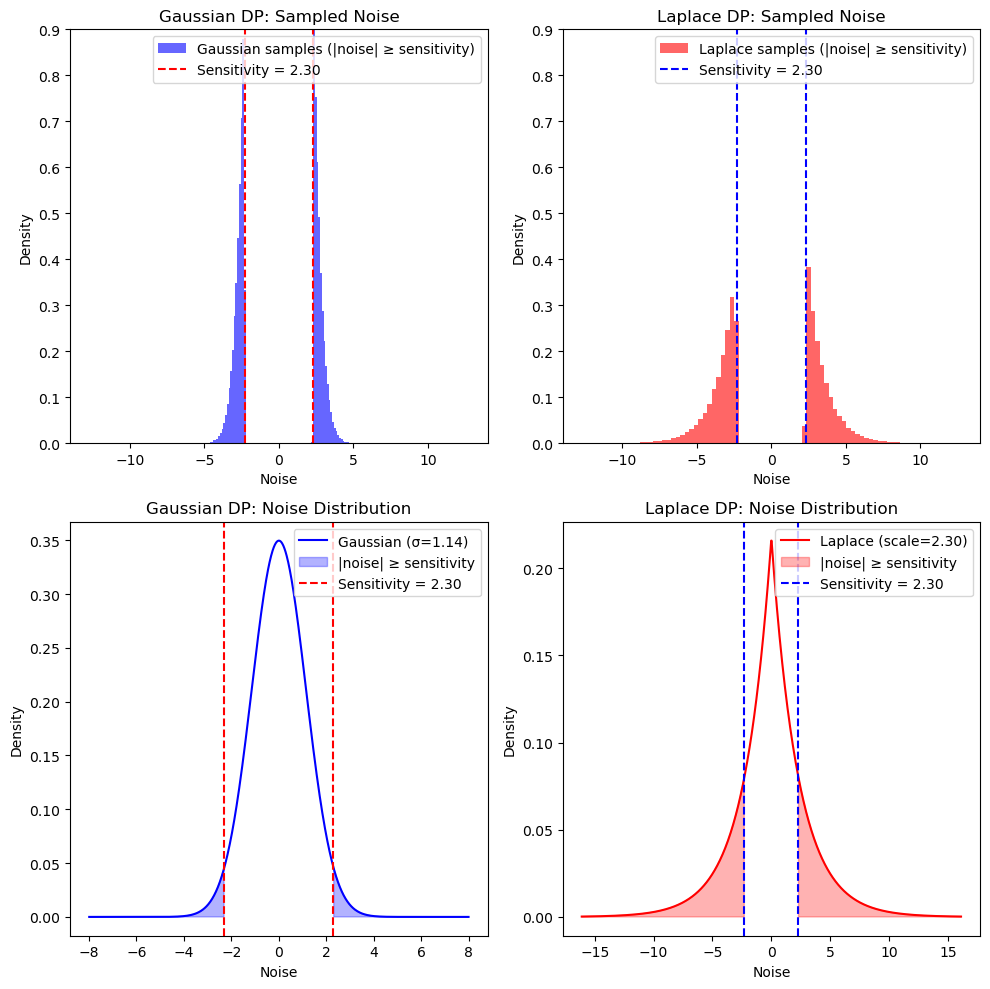

In [122]:
plt.figure(figsize=(10, 10))  

plt.subplot(2, 2, 1) 
plt.hist(noise_gaussian, bins=100, density=True, alpha=0.6, color='blue', 
         label='Gaussian samples (|noise| ≥ sensitivity)')
plt.axvline(x=sensitivity, color='red', linestyle='--', label=f'Sensitivity = {sensitivity:.2f}')
plt.axvline(x=-sensitivity, color='red', linestyle='--')
plt.title('Gaussian DP: Sampled Noise')
plt.xlabel('Noise')
plt.ylabel('Density')
plt.legend()
plt.xlim(-14, 14)
plt.ylim(0, 0.9)

plt.subplot(2, 2, 2)  
plt.hist(noise_laplace, bins=100, density=True, alpha=0.6, color='red', 
         label='Laplace samples (|noise| ≥ sensitivity)')
plt.axvline(x=sensitivity, color='blue', linestyle='--', label=f'Sensitivity = {sensitivity:.2f}')
plt.axvline(x=-sensitivity, color='blue', linestyle='--')
plt.title('Laplace DP: Sampled Noise')
plt.xlabel('Noise')
plt.ylabel('Density')
plt.legend()
plt.xlim(-14, 14)
plt.ylim(0, 0.9)

plt.subplot(2, 2, 3)  
x_g = np.linspace(-7*loo_scale, 7*loo_scale, 1000)
plt.plot(x_g, norm.pdf(x_g, 0, loo_scale), 'b-', label=f'Gaussian (σ={loo_scale:.2f})')
plt.fill_between(x_g, norm.pdf(x_g, 0, loo_scale), 
                 where=(np.abs(x_g) >= sensitivity), color='blue', alpha=0.3,
                 label='|noise| ≥ sensitivity')
plt.axvline(x=sensitivity, color='red', linestyle='--', label=f'Sensitivity = {sensitivity:.2f}')
plt.axvline(x=-sensitivity, color='red', linestyle='--')
plt.title('Gaussian DP: Noise Distribution')
plt.xlabel('Noise')
plt.ylabel('Density')
plt.legend()

plt.subplot(2, 2, 4)  
x_l = np.linspace(-7*scale_laplace, 7*scale_laplace, 1000)
plt.plot(x_l, laplace.pdf(x_l, 0, scale_laplace), 'r-', label=f'Laplace (scale={scale_laplace:.2f})')
plt.fill_between(x_l, laplace.pdf(x_l, 0, scale_laplace), 
                 where=(np.abs(x_l) >= sensitivity), color='red', alpha=0.3,
                 label='|noise| ≥ sensitivity')
plt.axvline(x=sensitivity, color='blue', linestyle='--', label=f'Sensitivity = {sensitivity:.2f}')
plt.axvline(x=-sensitivity, color='blue', linestyle='--')
plt.title('Laplace DP: Noise Distribution')
plt.xlabel('Noise')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

In [127]:
clean_data = np.random.normal(loc=170, scale=10, size=10)
loo_data = np.array([np.delete(clean_data, i) for i in range(len(clean_data))])
pipeline_output = user_output(loo_data)
loo_output = np.array([user_output(np.delete(clean_data, i)) for i in range(len(clean_data))])
print(f"loo_output: {list(loo_output)}, \npipeline_output: {pipeline_output}")
sensitivity = np.max(np.abs(loo_output - pipeline_output))
print(f"\nsensitivity: {sensitivity}")

n = len(clean_data)

loo_scale = np.std(loo_output)  
scale = max(loo_scale, sensitivity / np.sqrt(2 * np.log(1.1)))  
print(loo_scale, scale)
noise_gaussian = []
for _ in range(100000):
    while True:
        noise = np.random.normal(loc=0, scale=loo_scale)
        if np.abs(noise) >= sensitivity:
            noise_gaussian.append(noise)
            break

noise_gaussian_2 = []
for _ in range(100000):
    while True:
        noise = np.random.normal(loc=0, scale=scale)
        if np.abs(noise) >= sensitivity:
            noise_gaussian_2.append(noise)
            break



loo_output: [167.29298421536174, 168.951231805626, 167.90429140659361, 169.08533787514398, 168.08063268023494, 168.6547435782048, 169.22834441971384, 167.52166764319333, 169.30801119843176, 169.44493014702883], 
pipeline_output: 168.5472174969533

sensitivity: 1.254233281591553
0.7462506871330943 2.8727225171288286


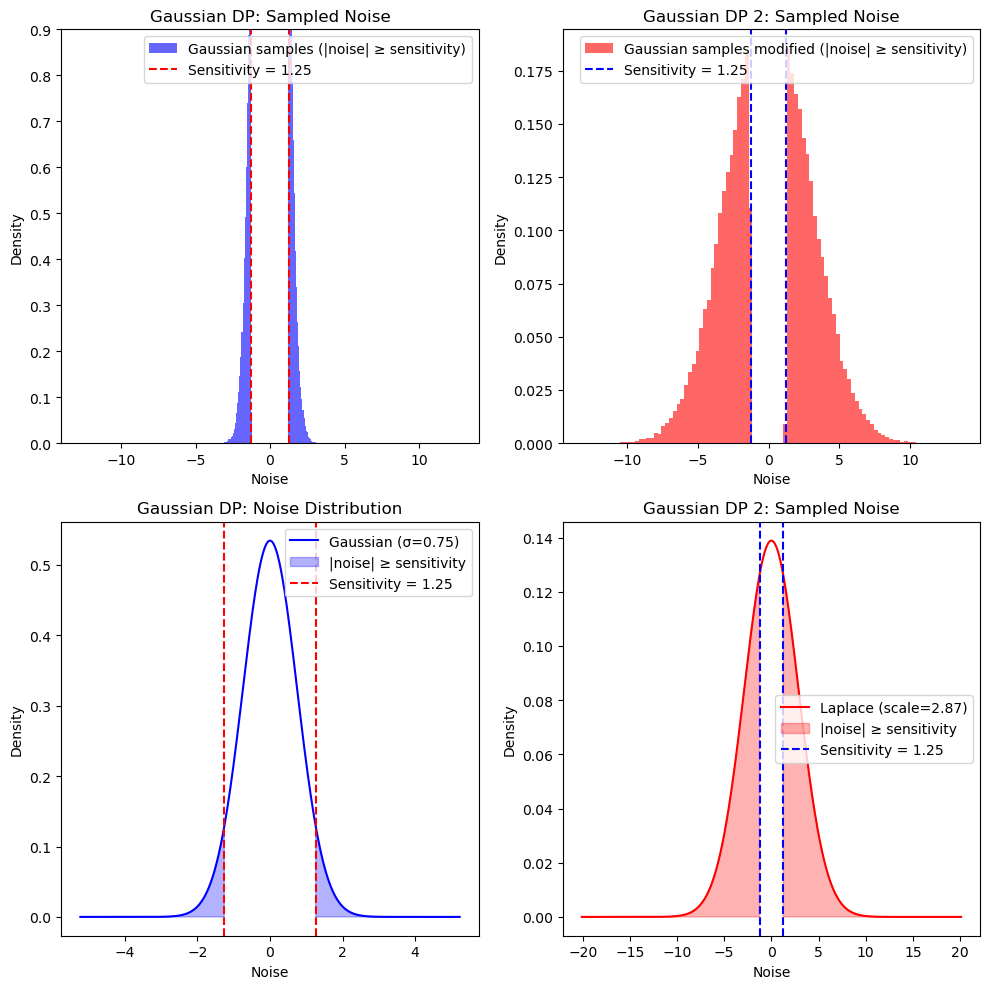

In [128]:
plt.figure(figsize=(10, 10))  

plt.subplot(2, 2, 1) 
plt.hist(noise_gaussian, bins=100, density=True, alpha=0.6, color='blue', 
         label='Gaussian samples (|noise| ≥ sensitivity)')
plt.axvline(x=sensitivity, color='red', linestyle='--', label=f'Sensitivity = {sensitivity:.2f}')
plt.axvline(x=-sensitivity, color='red', linestyle='--')
plt.title('Gaussian DP: Sampled Noise')
plt.xlabel('Noise')
plt.ylabel('Density')
plt.legend()
plt.xlim(-14, 14)
plt.ylim(0, 0.9)

plt.subplot(2, 2, 2)  
plt.hist(noise_gaussian_2, bins=100, density=True, alpha=0.6, color='red', 
         label='Gaussian samples modified (|noise| ≥ sensitivity)')
plt.axvline(x=sensitivity, color='blue', linestyle='--', label=f'Sensitivity = {sensitivity:.2f}')
plt.axvline(x=-sensitivity, color='blue', linestyle='--')
plt.title('Gaussian DP 2: Sampled Noise')
plt.xlabel('Noise')
plt.ylabel('Density')
plt.legend()


plt.subplot(2, 2, 3)  
x_g = np.linspace(-7*loo_scale, 7*loo_scale, 1000)
plt.plot(x_g, norm.pdf(x_g, 0, loo_scale), 'b-', label=f'Gaussian (σ={loo_scale:.2f})')
plt.fill_between(x_g, norm.pdf(x_g, 0, loo_scale), 
                 where=(np.abs(x_g) >= sensitivity), color='blue', alpha=0.3,
                 label='|noise| ≥ sensitivity')
plt.axvline(x=sensitivity, color='red', linestyle='--', label=f'Sensitivity = {sensitivity:.2f}')
plt.axvline(x=-sensitivity, color='red', linestyle='--')
plt.title('Gaussian DP: Noise Distribution')
plt.xlabel('Noise')
plt.ylabel('Density')
plt.legend()

plt.subplot(2, 2, 4)  
x_l = np.linspace(-7*scale, 7*scale, 1000)
plt.plot(x_l, norm.pdf(x_l, 0, scale), 'r-', label=f'Laplace (scale={scale:.2f})')
plt.fill_between(x_l, norm.pdf(x_l, 0, scale), 
                 where=(np.abs(x_l) >= sensitivity), color='red', alpha=0.3,
                 label='|noise| ≥ sensitivity')
plt.axvline(x=sensitivity, color='blue', linestyle='--', label=f'Sensitivity = {sensitivity:.2f}')
plt.axvline(x=-sensitivity, color='blue', linestyle='--')
plt.title('Gaussian DP 2: Sampled Noise')
plt.xlabel('Noise')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()